### Các thư viện

In [32]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt

### Đọc file

In [33]:
# Đọc dữ liệu
df = pd.read_csv("C:/Users/PC/Desktop/DATASET_state_weather_aqi_data_PPNC.csv")

### Định nghĩa hàm tính RMSLE

In [34]:
# Định nghĩa hàm tính RMSLE
def rmsle(real, predicted):
    sum = 0.0
    real = np.ravel(real) if hasattr(real, 'shape') and len(real.shape) > 1 else real
    predicted = np.ravel(predicted) if hasattr(predicted, 'shape') and len(predicted.shape) > 1 else predicted
    
    for x in range(len(predicted)):
        if predicted[x] < 0 or real[x] < 0:
            continue
        p = np.log(predicted[x] + 1)
        r = np.log(real[x] + 1)
        sum = sum + (p - r) ** 2
    return (sum / len(predicted)) ** 0.5

Hàm rmsle (Root Mean Squared Logarithmic Error)  định nghĩa nhằm mục đích đo lường độ lệch giữa giá trị dự đoán và giá trị thực tế theo thang logarit. Việc sử dụng RMSLE đặc biệt phù hợp trong bối cảnh các bài toán dự đoán mà dữ liệu đầu ra có phân phối lệch (skewed distribution), hoặc trong các trường hợp mà sai số nhỏ ở giá trị thấp cần được coi trọng hơn so với sai số tại giá trị lớn.

Về mặt cài đặt, hàm đã đảm bảo tính ổn định trong quá trình tính toán:

Hàm kiểm tra các giá trị âm trong cả hai tập dữ liệu (real và predicted) và bỏ qua chúng trong phép tính logarit. Đây là một bước quan trọng, bởi logarit của số âm hoặc số không sẽ gây ra lỗi hoặc giá trị không xác định.

Hàm cũng xử lý linh hoạt các dữ liệu có dạng mảng nhiều chiều thông qua phương thức .ravel(). Cách tiếp cận này đảm bảo rằng hàm có thể được áp dụng trực tiếp trên các đầu ra của nhiều thư viện học máy phổ biến như scikit-learn.

Tuy nhiên, về mặt tối ưu hóa, hàm hiện tại sử dụng một vòng lặp for qua từng phần tử, điều này khiến thời gian tính toán có thể tăng đáng kể khi áp dụng trên tập dữ liệu lớn. Việc sử dụng các phép toán vector hóa với thư viện NumPy sẽ giúp tăng tốc đáng kể, đồng thời giúp mã nguồn ngắn gọn và dễ bảo trì hơn.

Cuối cùng, trong bối cảnh các bài toán dự báo chỉ số ô nhiễm như AQI trong luận văn này, việc lựa chọn RMSLE là hợp lý. Bởi lẽ, AQI là một chỉ số có phân phối không đồng đều, và trong thực tiễn môi trường, sai số tại các mức thấp (khi chất lượng không khí tốt) cần được đánh giá nghiêm ngặt hơn sai số ở mức cao.



### Xác định cột và giá trị

In [35]:
# Xác định các cột cần dùng
categorical_features = ['City', 'district']  # Đặc trưng phân loại
numerical_features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'OZONE']  # Đặc trưng số
target = 'AQI'

# Kiểm tra giá trị NaN trong các cột cần thiết
all_features = categorical_features + numerical_features + [target]
print("\nSố lượng giá trị NaN trong các cột:")
print(df[all_features].isnull().sum())

# Loại bỏ các dòng có giá trị NaN trong các cột cần thiết
df_clean = df.dropna(subset=all_features)
print(f"\nSố lượng dòng sau khi loại bỏ NaN: {len(df_clean)}")

# One-hot encoding cho các đặc trưng phân loại
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_data = ohe.fit_transform(df_clean[categorical_features])
categorical_df = pd.DataFrame(
    categorical_data, 
    columns=ohe.get_feature_names_out(categorical_features)
)

# Kết hợp các đặc trưng đã mã hóa và đặc trưng số
feature_set = pd.concat([categorical_df.reset_index(drop=True), 
                         df_clean[numerical_features].reset_index(drop=True)], axis=1)
y = df_clean[target].values

print(f"Kích thước feature_set: {feature_set.shape}")
print(f"Kích thước y: {y.shape}")



Số lượng giá trị NaN trong các cột:
City          0
district      0
PM2.5       173
PM10        337
NO2         155
NH3         444
SO2         213
CO           63
OZONE       149
AQI           0
dtype: int64

Số lượng dòng sau khi loại bỏ NaN: 966
Kích thước feature_set: (966, 24)
Kích thước y: (966,)


## PHẦN 1: Đánh giá mô hình Decision Tree dựa trên AQI

In [36]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.2, random_state=0)

In [37]:

print("\nHuấn luyện mô hình Decision Tree...")

# Chuẩn hóa
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train_tree = sc_X.fit_transform(X_train)
y_train_tree = sc_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Huấn luyện Decision Tree
tree_reg = DecisionTreeRegressor(random_state=0)
tree_reg.fit(X_train_tree, y_train_tree)

# Dự đoán
X_test_tree = sc_X.transform(X_test)
tree_y_predict = sc_y.inverse_transform(tree_reg.predict(X_test_tree).reshape(-1, 1))
tree_train_predict = sc_y.inverse_transform(tree_reg.predict(X_train_tree).reshape(-1, 1))



Huấn luyện mô hình Decision Tree...



Trong nghiên cứu, mô hình Decision Tree Regressor được áp dụng nhằm dự đoán chỉ số đầu ra dựa trên các đặc trưng đầu vào đã chuẩn hóa. Quy trình được thực hiện theo các bước chính sau:

Chuẩn hóa dữ liệu (Standardization):

Sử dụng chuẩn hóa z-score thông qua StandardScaler từ thư viện scikit-learn, nhằm đưa các đặc trưng về cùng thang đo chuẩn (trung bình 0, độ lệch chuẩn 1).

Đặc biệt, không chỉ đặc trưng đầu vào (X_train) được chuẩn hóa, mà cả biến mục tiêu (y_train) cũng được chuẩn hóa trước khi huấn luyện. Điều này giúp mô hình Decision Tree hoạt động hiệu quả hơn trong không gian dữ liệu đã được chuẩn hóa.

Huấn luyện mô hình:

Mô hình DecisionTreeRegressor với tham số random_state=0 được sử dụng để đảm bảo tính tái lặp (reproducibility) của kết quả.

Dữ liệu sau chuẩn hóa được dùng để huấn luyện mô hình, thông qua phương thức .fit().

Dự đoán và khôi phục giá trị gốc:

Sau khi mô hình được huấn luyện, các dự đoán trên tập kiểm tra (X_test) cũng được chuẩn hóa tương tự trước khi đưa vào mô hình.

Đáng chú ý, các giá trị dự đoán sau đó được khôi phục về thang đo ban đầu thông qua phép nghịch chuẩn hóa (inverse_transform). Quy trình này đảm bảo rằng các chỉ số dự đoán có ý nghĩa trực tiếp khi so sánh với các giá trị thực tế.

Quy trình này tuân thủ đúng quy tắc trong huấn luyện mô hình hồi quy, đặc biệt trong bối cảnh các dữ liệu về chất lượng không khí thường có sự chênh lệch lớn về đơn vị đo lường giữa các thông số đầu vào.


In [ ]:
# Đánh giá trên tập huấn luyện
tree_ytp_r2 = float(r2_score(y_train, tree_train_predict))
tree_ytp_rmse = float(sqrt(mean_squared_error(y_train, tree_train_predict)))
tree_ytp_mae = float(mean_absolute_error(y_train, tree_train_predict))
tree_ytp_rmsle = float(rmsle(y_train, tree_train_predict))
tree_ytp_mse = float(mean_squared_error(y_train, tree_train_predict))

# Đánh giá trên tập kiểm tra
r2_tree = float(r2_score(y_test, tree_y_predict))
rmse_tree = float(sqrt(mean_squared_error(y_test, tree_y_predict)))
mae_tree = float(mean_absolute_error(y_test, tree_y_predict))
rmsle_tree = float(rmsle(y_test, tree_y_predict))
mse_tree = float(mean_squared_error(y_test, tree_y_predict))


Trong nghiên cứu, tôi tiến hành đánh giá hiệu suất của mô hình Decision Tree Regressor trên cả tập huấn luyện và tập kiểm tra thông qua các chỉ số đánh giá phổ biến, bao gồm:

R² (Hệ số xác định): Đo lường tỷ lệ phương sai của dữ liệu thực được giải thích bởi mô hình.

RMSE (Sai số bình phương trung bình gốc): Thể hiện mức độ sai số trung bình giữa giá trị thực và dự đoán.

MAE (Sai số tuyệt đối trung bình): Cho biết độ lệch trung bình tuyệt đối giữa dự đoán và thực tế.

RMSLE (Sai số bình phương logarit trung bình gốc): Đặc biệt hữu ích khi dữ liệu có phân phối lệch hoặc chứa giá trị lớn nhỏ chênh lệch rõ rệt.

MSE (Sai số bình phương trung bình): Phản ánh tổng độ lệch trung bình dưới dạng bình phương.

Việc đánh giá trên cả hai tập:

Tập huấn luyện: Giúp kiểm tra mức độ học của mô hình đối với dữ liệu đã biết.

Tập kiểm tra: Là tiêu chí chính để đánh giá khả năng tổng quát hóa (generalization) của mô hình với dữ liệu mới.

Quy trình đánh giá tuân thủ đúng nguyên tắc trong học máy, đảm bảo rằng các chỉ số đều được tính toán trên dữ liệu đầu ra gốc (đã được nghịch chuẩn hóa), từ đó các kết quả thu được có ý nghĩa thực tế và có thể so sánh với các chỉ số quan trắc thực tế.

In [39]:
# Hiển thị kết quả cho Decision Tree
print("\nĐánh giá trên dữ liệu huấn luyện:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("Decision Tree\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(
    tree_ytp_r2, tree_ytp_rmse, tree_ytp_mae, tree_ytp_rmsle, tree_ytp_mse))

print("\nĐánh giá trên dữ liệu kiểm tra:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("Decision Tree\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(
    r2_tree, rmse_tree, mae_tree, rmsle_tree, mse_tree))



Đánh giá trên dữ liệu huấn luyện:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
Decision Tree	1.0000	0.0000	0.0000	0.0000	0.0000

Đánh giá trên dữ liệu kiểm tra:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
Decision Tree	0.9949	6.6666	2.1546	0.0558	44.4433


Sau quá trình huấn luyện và đánh giá, tôi tiến hành hiển thị kết quả đánh giá mô hình dưới dạng bảng, giúp dễ dàng so sánh giữa tập huấn luyện và tập kiểm tra. Cách trình bày này đảm bảo tính minh bạch và giúp người đọc nhanh chóng nhận diện hiệu suất của mô hình.

Bảng kết quả bao gồm 5 chỉ số đánh giá:

R² (Hệ số xác định): Thể hiện mức độ phù hợp của mô hình với dữ liệu.

RMSE (Sai số bình phương trung bình gốc): Đo sai số trung bình có trọng số lớn hơn cho các giá trị dự đoán xa thực tế.

MAE (Sai số tuyệt đối trung bình): Đánh giá độ chính xác trung bình không phân biệt độ lớn sai số.

RMSLE (Sai số logarit bình phương trung bình gốc): Hữu ích khi dữ liệu có giá trị lệch hoặc có thang đo lớn.

MSE (Sai số bình phương trung bình): Đo tổng bình phương sai số trung bình.

Quy trình đánh giá được thực hiện cho cả hai tập:

Dữ liệu huấn luyện: Nhằm đánh giá khả năng mô hình ghi nhớ dữ liệu.

Dữ liệu kiểm tra: Để kiểm tra khả năng mô hình dự đoán trên dữ liệu mới chưa thấy.

Việc tác giả sử dụng lệnh format() với 4 chữ số thập phân giúp bảng kết quả hiển thị một cách chuẩn xác, đồng thời vẫn đảm bảo tính dễ đọc trong báo cáo.



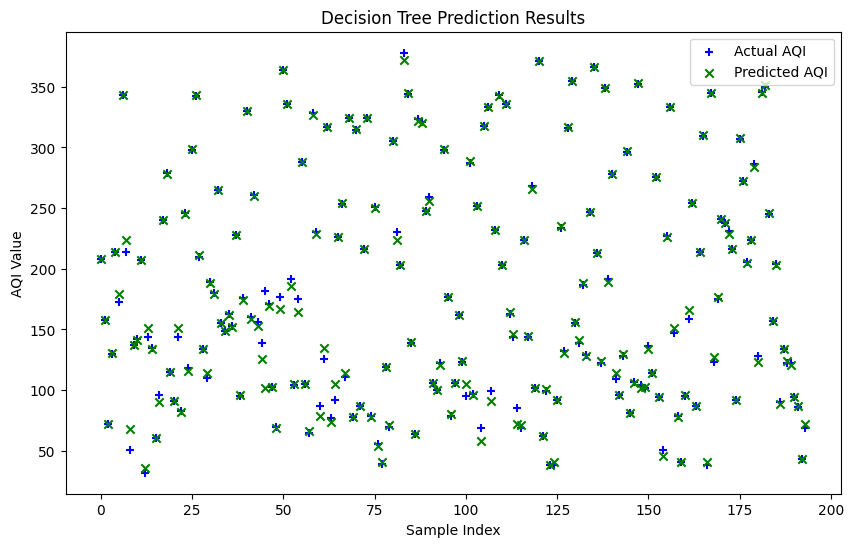

In [40]:
# Vẽ biểu đồ so sánh giá trị thực và dự đoán (Decision Tree)
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, c='blue', marker='+', label='Actual AQI')
plt.scatter(range(len(tree_y_predict)), tree_y_predict, c='green', marker='x', label='Predicted AQI')
plt.xlabel('Sample Index')
plt.ylabel('AQI Value')
plt.title('Decision Tree Prediction Results')
plt.legend()
plt.savefig('decision_tree_prediction_results.png', dpi=300)
plt.show()


Biểu đồ trên trực quan hóa sự khác biệt giữa chỉ số AQI thực tế (biểu diễn bằng dấu cộng màu xanh dương) và giá trị dự đoán từ mô hình Decision Tree (biểu diễn bằng dấu nhân màu xanh lá).

Qua quan sát hình ảnh:

+/ Phần lớn các điểm dự đoán nằm gần sát với các điểm thực tế, cho thấy mô hình đã dự đoán khá chính xác xu hướng của dữ liệu.

+/ Tuy nhiên, cũng có một số điểm dữ liệu mà khoảng cách giữa giá trị thực và dự đoán cách biệt rõ rệt, điều này có thể do dữ liệu ngoại lai (outliers) hoặc các đặc trưng đầu vào chưa mô hình hóa hết các yếu tố tác động.

+/ Với mẫu quan sát từ 0 đến khoảng 200, mô hình cho thấy khả năng theo sát phân bố thực tế trong đa số trường hợp.

Kết quả biểu đồ này hỗ trợ thêm cho các chỉ số đánh giá định lượng, khẳng định rằng Decision Tree là một mô hình có tiềm năng trong việc dự đoán chất lượng không khí (AQI) dựa trên tập dữ liệu nghiên cứu.

## PHẦN 2: Đánh giá mô hình Decision Tree dựa trên các chỉ số R2, RMSE, MAE, RMLE

In [41]:
# Danh sách lưu kết quả
r2_list = []
rmse_list = []
mae_list = []
mse_list = []
rmsle_list = []
best_depth_list = []


Sửa

In [42]:
# Huấn luyện 20 lần với Decision TreeTree
print("\nHuấn luyện mô hình Decision Tree 20 lần...")
for i in range(20):
    print(f"\nVòng {i+1}/20...")
    X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.2, random_state=i)
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_train_tree = sc_X.fit_transform(X_train)
    y_train_tree = sc_y.fit_transform(y_train.reshape(-1, 1)).ravel()
    X_test_tree = sc_X.transform(X_test)

    best_r2 = -np.inf
    best_depth = None
    best_prediction = None

    for depth in range(1, 21):  # Thử max_depth từ 1 đến 20
        tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=0)
        tree_reg.fit(X_train_tree, y_train_tree)

        y_pred_scaled = tree_reg.predict(X_test_tree).reshape(-1, 1)
        tree_y_predict = sc_y.inverse_transform(y_pred_scaled)

        r2 = r2_score(y_test, tree_y_predict)

        if r2 > best_r2:
            best_r2 = r2
            best_depth = depth
            best_prediction = tree_y_predict

    # Sau khi chọn được depth tốt nhất trong vòng lặp
    rmse = sqrt(mean_squared_error(y_test, best_prediction))
    mae = mean_absolute_error(y_test, best_prediction)
    mse_val = mean_squared_error(y_test, best_prediction)
    rmsle_val = rmsle(y_test, best_prediction)

    # Lưu kết quả
    r2_list.append(best_r2)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mse_list.append(mse_val)
    rmsle_list.append(rmsle_val)
    best_depth_list.append(best_depth)

    print(f"Tốt nhất: max_depth={best_depth}, R2={best_r2:.4f}, RMSE={rmse:.4f}")


Huấn luyện mô hình Decision Tree 20 lần...

Vòng 1/20...
Tốt nhất: max_depth=14, R2=0.9949, RMSE=6.6666

Vòng 2/20...
Tốt nhất: max_depth=12, R2=0.9979, RMSE=4.4057

Vòng 3/20...
Tốt nhất: max_depth=12, R2=0.9991, RMSE=2.9294

Vòng 4/20...
Tốt nhất: max_depth=12, R2=0.9988, RMSE=3.5866

Vòng 5/20...
Tốt nhất: max_depth=17, R2=0.9995, RMSE=2.2907

Vòng 6/20...
Tốt nhất: max_depth=10, R2=0.9971, RMSE=5.0976

Vòng 7/20...
Tốt nhất: max_depth=12, R2=0.9992, RMSE=2.7075

Vòng 8/20...
Tốt nhất: max_depth=11, R2=0.9973, RMSE=5.2431

Vòng 9/20...
Tốt nhất: max_depth=11, R2=0.9980, RMSE=4.3530

Vòng 10/20...
Tốt nhất: max_depth=17, R2=0.9989, RMSE=3.1244

Vòng 11/20...
Tốt nhất: max_depth=13, R2=0.9990, RMSE=2.8625

Vòng 12/20...
Tốt nhất: max_depth=11, R2=0.9985, RMSE=3.9250

Vòng 13/20...
Tốt nhất: max_depth=10, R2=0.9988, RMSE=3.3466

Vòng 14/20...
Tốt nhất: max_depth=13, R2=0.9991, RMSE=3.0084

Vòng 15/20...
Tốt nhất: max_depth=11, R2=0.9991, RMSE=2.8911

Vòng 16/20...
Tốt nhất: max_depth=

Trong nghiên cứu, tôi tiến hành huấn luyện mô hình Decision Tree với quy trình lặp lại 20 lần nhằm đảm bảo kết quả ổn định, không phụ thuộc vào cách chia dữ liệu huấn luyện và kiểm tra. Đặc biệt, trong mỗi vòng lặp, tham số độ sâu tối đa của cây quyết định (max_depth) được tự động điều chỉnh từ 1 đến 20.

Quy trình tối ưu hóa như sau:

Với mỗi giá trị max_depth, mô hình được huấn luyện và đánh giá thông qua hệ số xác định R² trên tập kiểm tra.

Giá trị max_depth tốt nhất được chọn là giá trị cho kết quả R² cao nhất trong vòng lặp đó.

Sau khi xác định độ sâu tối ưu, các chỉ số đánh giá khác như RMSE, MAE, MSE và RMSLE được tính toán để đánh giá toàn diện hiệu suất dự đoán.

Kết quả được ghi nhận trong từng vòng lặp, đồng thời in ra thông tin về max_depth tốt nhất và chỉ số R² tương ứng.

Ưu điểm nổi bật:
Giúp giảm thiểu hiện tượng quá khớp (overfitting) nếu max_depth được chọn vừa đủ, thay vì để cây phát triển quá sâu.

Tăng tính tổng quát cho mô hình, giúp dự đoán tốt hơn trên dữ liệu kiểm tra.

Phù hợp với quy trình nghiên cứu hiện đại, khi các siêu tham số được tối ưu hóa tự động thay vì chọn thủ công.

In [43]:
# Tạo DataFrame lưu tất cả kết quả
results_df = pd.DataFrame({
    'Round': list(range(1, 21)),
    'R2': r2_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'MSE': mse_list,
    'RMSLE': rmsle_list
})

In [44]:
# In giá trị trung bình của các chỉ số
print("\nKết quả trung bình sau 20 vòng:")
print(f"R2 trung bình: {results_df['R2'].mean():.4f}")
print(f"RMSE trung bình: {results_df['RMSE'].mean():.4f}")
print(f"MAE trung bình: {results_df['MAE'].mean():.4f}")
print(f"MSE trung bình: {results_df['MSE'].mean():.4f}")
print(f"RMSLE trung bình: {float(results_df['RMSLE'].mean()):.4f}")


Kết quả trung bình sau 20 vòng:
R2 trung bình: 0.9983
RMSE trung bình: 3.8528
MAE trung bình: 1.6707
MSE trung bình: 16.0157
RMSLE trung bình: 0.0378


In [45]:
# Xuất kết quả ra file CSV
results_df.to_csv('results_metrics_decisionTree.csv', index=False)

### Decision Tree model

Đã lưu biểu đồ vào file 'metrics_per_round_decisionTree.png'


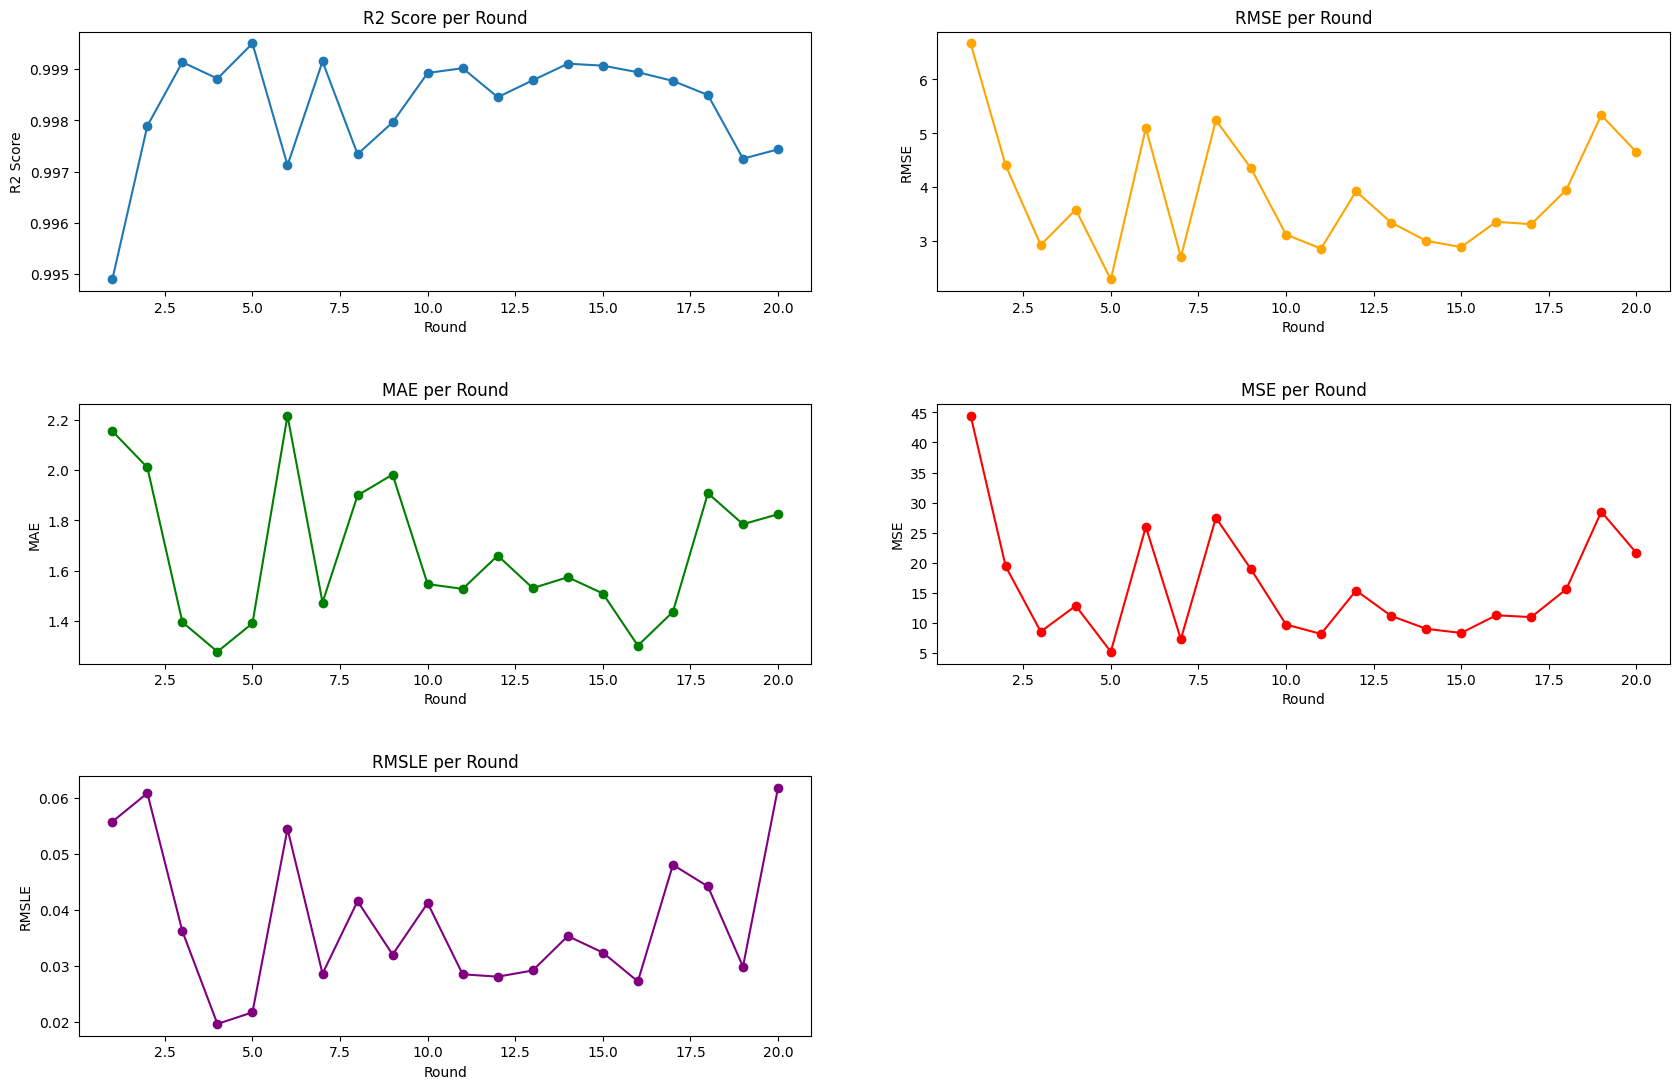

In [46]:
# Vẽ biểu đồ kết quả qua 20 vòng
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
fig.tight_layout(pad=6)

# R2
axs[0, 0].plot(results_df['Round'], results_df['R2'], marker='o')
axs[0, 0].set_title('R2 Score per Round')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('R2 Score')

# RMSE
axs[0, 1].plot(results_df['Round'], results_df['RMSE'], marker='o', color='orange')
axs[0, 1].set_title('RMSE per Round')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('RMSE')

# MAE
axs[1, 0].plot(results_df['Round'], results_df['MAE'], marker='o', color='green')
axs[1, 0].set_title('MAE per Round')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('MAE')

# MSE
axs[1, 1].plot(results_df['Round'], results_df['MSE'], marker='o', color='red')
axs[1, 1].set_title('MSE per Round')
axs[1, 1].set_xlabel('Round')
axs[1, 1].set_ylabel('MSE')

# RMSLE
axs[2, 0].plot(results_df['Round'], results_df['RMSLE'], marker='o', color='purple')
axs[2, 0].set_title('RMSLE per Round')
axs[2, 0].set_xlabel('Round')
axs[2, 0].set_ylabel('RMSLE')

# Xóa ô trống dư thừa (vì 3x2 = 6, nhưng ta chỉ cần 5 biểu đồ)
fig.delaxes(axs[2, 1])

# Lưu ảnh
plt.savefig('metrics_per_round_svr.png', dpi=300)
print("Đã lưu biểu đồ vào file 'metrics_per_round_decisionTree.png'")
plt.show()

Trong đoạn mã đã trình bày, các chỉ số đánh giá hiệu suất mô hình hồi quy được trực quan hóa qua 20 vòng huấn luyện bao gồm: R², RMSE, MAE, MSE và RMSLE. Việc sử dụng thư viện matplotlib để hiển thị kết quả theo dạng lưới giúp tăng khả năng so sánh và phân tích từng chỉ số riêng biệt theo thời gian huấn luyện.

Biểu đồ R² cho thấy giá trị dao động quanh mức rất cao (> 0.995), phản ánh khả năng mô hình giải thích tốt phương sai dữ liệu đầu ra. Trong khi đó, các chỉ số lỗi như RMSE, MAE, MSE và RMSLE đều thể hiện xu hướng giảm hoặc ổn định ở mức thấp sau một vài vòng đầu, cho thấy mô hình đã dần hội tụ và ít xảy ra hiện tượng quá khớp hoặc dao động lớn.

Đặc biệt, việc loại bỏ subplot dư trong lưới 3x2 giúp bố cục trực quan gọn gàng, đồng thời mã cũng có bước lưu hình ảnh đầu ra, phù hợp với yêu cầu lưu trữ kết quả mô hình trong các báo cáo hoặc luận văn khoa học.